In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from statannotations.Annotator import Annotator
from pathlib import Path
from helper.evaluation_helper import cv_evaluate

#network_types = ["large", "biogrid", "iid"]
#target_dbs = ["DRH", "DC", "TTD", "Merged", "BDB"]
network_types = ["large"]
target_dbs = ["DRH"]

In [2]:
scoring = ['balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc']
n_estimators = 1000
random_state = 231222
sampling = RandomUnderSampler(random_state=random_state)

for network_type in network_types:
    print(network_type)
    for target_db in target_dbs:
        print(target_db)
        original = pd.read_csv(f'../2_feature_extraction/{network_type}/features_{target_db} Target.csv', index_col=0)
        original = original.drop(['Target', 'Neighbor'], axis=1)
        original = original[original['Outcome'] != 'Very Weak']
        original = original[original['Outcome'] != 'Low']
        original['Outcome'] = original['Outcome'].replace({'Weak': 'Effect'})
        original['Outcome'] = original['Outcome'].replace({'Strong': 'Effect'})
        original['Outcome'] = original['Outcome'].replace({'No-Effect': 0, 'Cyto': -1, 'Effect': 1})
        outcomes = ['No-Effect vs. Effect', 'No-Effect vs. Cyto', 'Cyto vs. Effect']
        results = {}
        results_random = {}
        for outcome in outcomes:
            print(" "  + outcome)
            data = original.copy()
            os = outcome.split(' vs. ')
            drop_outcome = None
            if 'Effect' not in os:
                drop_outcome = 1
                data = data[data['Outcome'] != drop_outcome]
                data['Outcome'] = data['Outcome'].replace({-1: 1})
            elif 'Cyto' not in os:
                drop_outcome = -1
                data = data[data['Outcome'] != drop_outcome]
            elif 'No-Effect' not in os:
                drop_outcome = 0
                data = data[data['Outcome'] != drop_outcome]
                data['Outcome'] = data['Outcome'].replace({-1: 0})
            else:
                raise Exception()

            data = data.dropna()
            labels = data.copy().loc[:, 'Outcome']
            features = data.copy().drop('Outcome', axis=1)

            cv_result, model, X_train, y_train, X_test, y_test = cv_evaluate(features=features, labels=labels, sampling=sampling, n_estimators=n_estimators, scoring=scoring)
            results[outcome] = {'cv_evaluation': cv_result, 'model': model, 'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
            y_pred = model.predict(X_test)
            cv_result, rand_model, _, _, rand_X_test, rand_y_test = cv_evaluate(features, labels.sample(frac=1.0, random_state=random_state), sampling=sampling, n_estimators=n_estimators, scoring=scoring)
            results_random[outcome] = {'cv_evaluation': cv_result, 'model': None}
            rand_y_pred = rand_model.predict(rand_X_test)

        target_results = {'real': results, 'random': results_random}

        Path(f'{network_type}/{target_db}').mkdir(parents=True, exist_ok=True)
        joblib.dump(target_results, f'{network_type}/{target_db}/results.sav')

large
DRH
 No-Effect vs. Effect
 No-Effect vs. Cyto
 Cyto vs. Effect


large
DRH


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


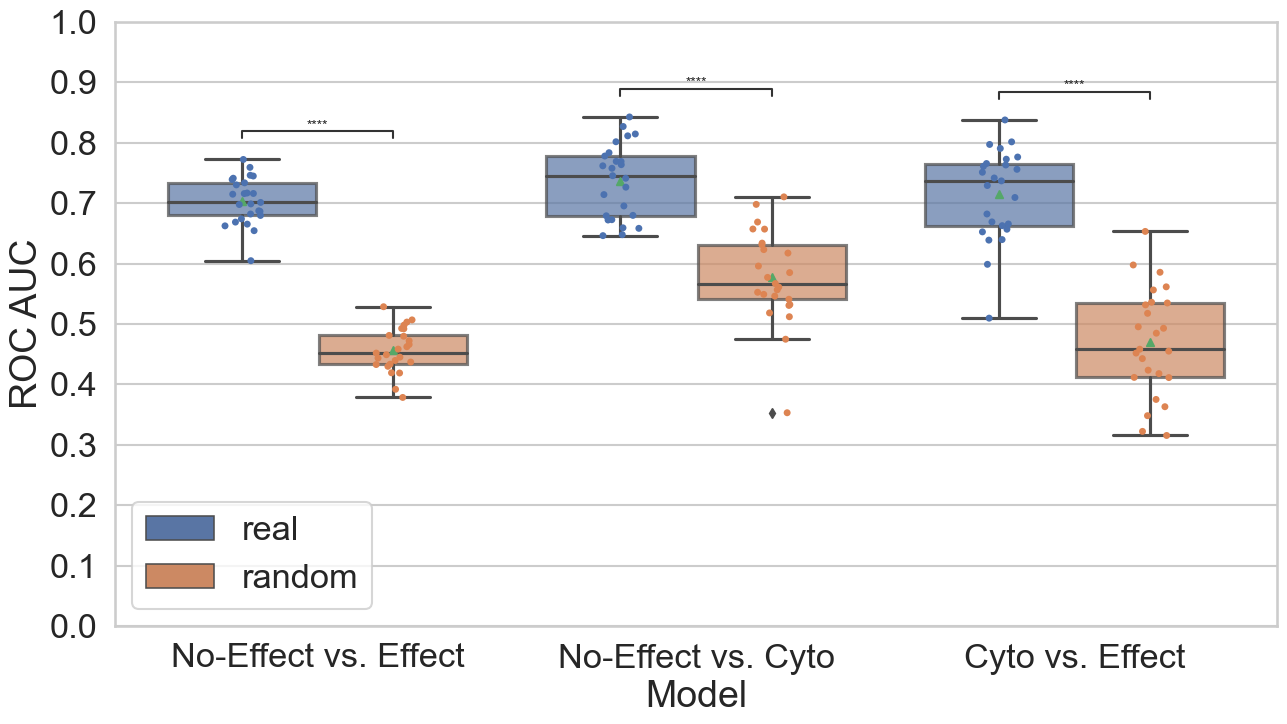

large
DRH


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


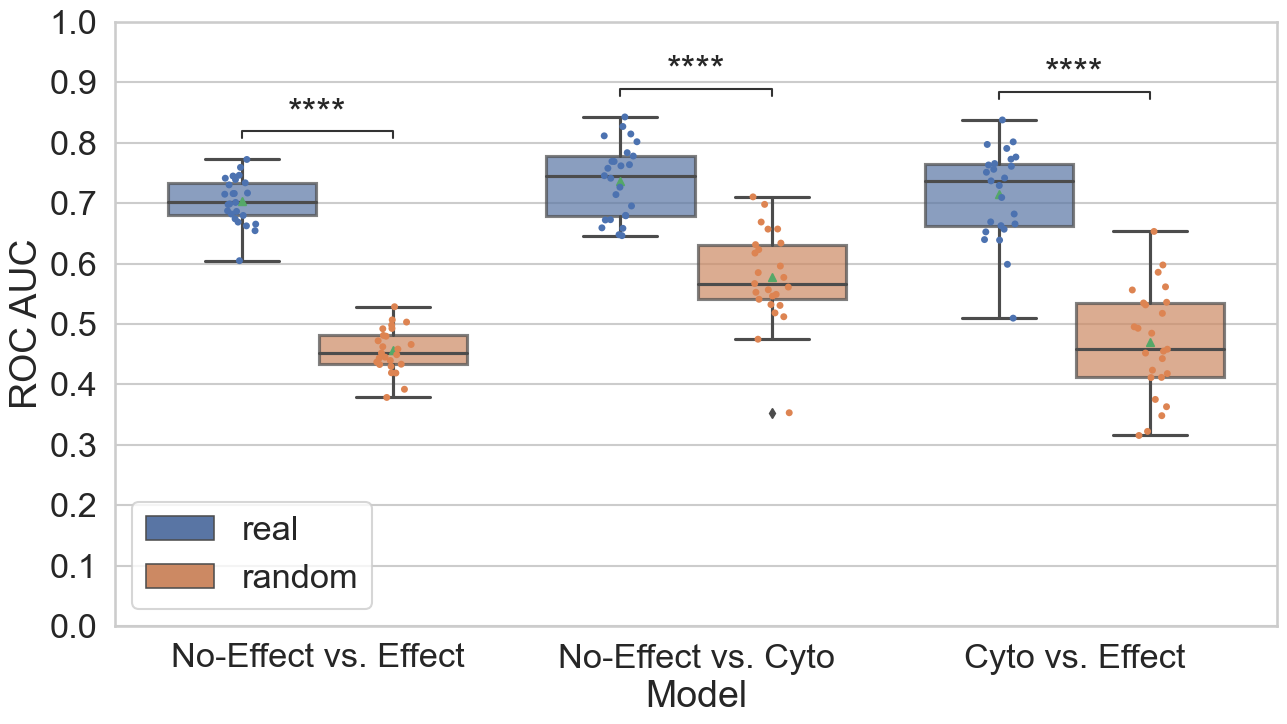

In [4]:
for network_type in network_types:
    print(network_type)
    for target_db in target_dbs:
        print(target_db)
        target_results = joblib.load(f'{network_type}/{target_db}/results.sav')
        model_evaluations = []

        results = target_results['real']
        for key in results.keys():
            for score in scoring:
                result = results[key]['cv_evaluation'].loc[:, f'test_{score}'].to_frame()
                result['model'] = key
                result['labels'] = 'real'
                result['metric'] = score
                result.columns = ['score', 'model', 'labels', 'metric']
                model_evaluations.append(result)

        results_random = target_results['random']
        for key in results.keys():
            for score in scoring:
                result_random = results_random[key]['cv_evaluation'].loc[:, f'test_{score}'].to_frame()
                result_random['model'] = key
                result_random['labels'] = 'random'
                result_random['metric'] = score
                result_random.columns = ['score', 'model', 'labels', 'metric']
                model_evaluations.append(result_random)

        scores = pd.concat(model_evaluations)
        scores = scores[scores['metric'] == "roc_auc"]

        sns.set("talk", font_scale=1.5)
        sns.set_style("whitegrid")
        fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=100)
        sns.boxplot(data=scores, x='model', y='score', hue='labels', showmeans=True, ax=ax, boxprops=dict(alpha=.7))
        sns.stripplot(data=scores, x='model', y='score', hue='labels', ax=ax, dodge=True, jitter=True, alpha=1.0)
        pairs = [(('No-Effect vs. Cyto', 'real'), ('No-Effect vs. Cyto', 'random')),
                 (('No-Effect vs. Effect', 'real'), ('No-Effect vs. Effect', 'random')),
                 (('Cyto vs. Effect', 'real'), ('Cyto vs. Effect', 'random'))]
        annotator = Annotator(ax, pairs, data=scores, x="model", y="score", hue="labels")
        annotator.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0, text_offset=0, line_offset=0.0)
        annotator.apply_and_annotate()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], labels[:2])
        ax.set(ylabel='ROC AUC')
        ax.set(xlabel='Model')
        ax.set(yticks=np.arange(0.0, 1.1, step=0.1))
        fig.savefig(f'{network_type}/{target_db}/cv_evaluation.png', format="png", dpi=300)
        fig.savefig(f'{network_type}/{target_db}/cv_evaluation.eps', format="eps", dpi=300)
        fig.savefig(f'{network_type}/{target_db}/cv_evaluation.pdf', format="pdf", dpi=300)
        fig.savefig(f'{network_type}/{target_db}/cv_evaluation.svg', format="svg", dpi=300)